In [1]:
get_ipython().run_line_magic('matplotlib', 'widget')

In [2]:
pip install rocketcea

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install jsonpickle

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install windrose

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install simplekml

Note: you may need to restart the kernel to use updated packages.


In [8]:
!pip install --upgrade cffi

In [9]:
pip install --upgrade rocketpy

Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install timezonefinder

Note: you may need to restart the kernel to use updated packages.


In [11]:
from datetime import datetime
from time import process_time, perf_counter, time
import glob

from rocketpy import Environment, Rocket, LiquidMotor, Flight, Function
from rocketpy.motors import Tank, TankGeometry, Fluid

import numpy as np
from numpy.random import normal, uniform, choice
from IPython.display import display

In [12]:
%config InlineBackend.figure_formats = ['svg']
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.rcParams["figure.figsize"] = [8, 5]
mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["font.size"] = 14
mpl.rcParams["legend.fontsize"] = 14
mpl.rcParams["figure.titlesize"] = 14

In [13]:
import rocketcea
import os
import numpy as np
import scipy
from scipy.optimize import minimize
import tkinter as tk
import matplotlib.pyplot as plt
import matplotlib
print(matplotlib.matplotlib_fname())
from rocketcea.cea_obj import CEA_Obj
import pandas as pd
import math
import datetime

class propellant:
    def __init__(self,name, density, viscosity,tank_length, tank_radius, temperature):
        self.density = density
        self.viscosity = viscosity
        self.temp = temperature
        self.rad = tank_radius
        self.length = tank_length
        self.name = name
        return None
    def __str__(self) -> str:
        return self.name

/opt/conda/lib/python3.9/site-packages/matplotlib/mpl-data/matplotlibrc


In [14]:
from rocketpy import Environment, Rocket, LiquidMotor, Flight

In [15]:
import datetime
import numpy as np
import matplotlib.pyplot as plt

In [16]:
%matplotlib widget

In [17]:
env = Environment(
    latitude=32.9901, 
    longitude=-106.9751, 
    elevation=1400.556
)

tomorrow = datetime.date.today() + datetime.timedelta(days=1)

env.set_date(
  (tomorrow.year, tomorrow.month, tomorrow.day, 12), timezone="America/Denver"
) # Tomorrow's date in year, month, day, hour UTC format

env.set_atmospheric_model(type='Forecast', file='GFS')

#
#Env.setAtmosphericModel(type="CustomAtmosphere", wind_v=-5)


oc_open: server error retrieving url: code=0 message="/gfs_0p25/gfs20230928/gfs_0p25_00z is not an available dataset"


Gravity Details

Acceleration of Gravity at Lauch Site: 9.791112956972544 m/s²


Launch Site Details

Launch Date: 2023-09-28 18:00:00 UTC | 2023-09-28 12:00:00 America/Denver
Launch Site Latitude: 32.99010°
Launch Site Longitude: -106.97510°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 315458.79 W    3651921.75 N
Launch Site UTM zone: 13S
Launch Site Surface Elevation: 1471.3 m


Atmospheric Model Details

Atmospheric Model Type: Forecast
Forecast Maximum Height: 79.030 km
Forecast Time Period: From  2023-09-27 18:00:00  to  2023-10-13 18:00:00  UTC
Forecast Hour Interval: 3  hrs
Forecast Latitude Range: From  -90.0 ° To  90.0 °
Forecast Longitude Range: From  0.0 ° To  359.75 °


Surface Atmospheric Conditions

Surface Wind Speed: 3.41 m/s
Surface Wind Direction: 208.31°
Surface Wind Heading: 28.31°
Surface Pressure: 853.56 hPa
Surface Temperature: 301.24 K
Surface Air Density: 0.987 kg/m³
Surface Speed of Sound: 347.94 m/s


Atmospheric Model Plots



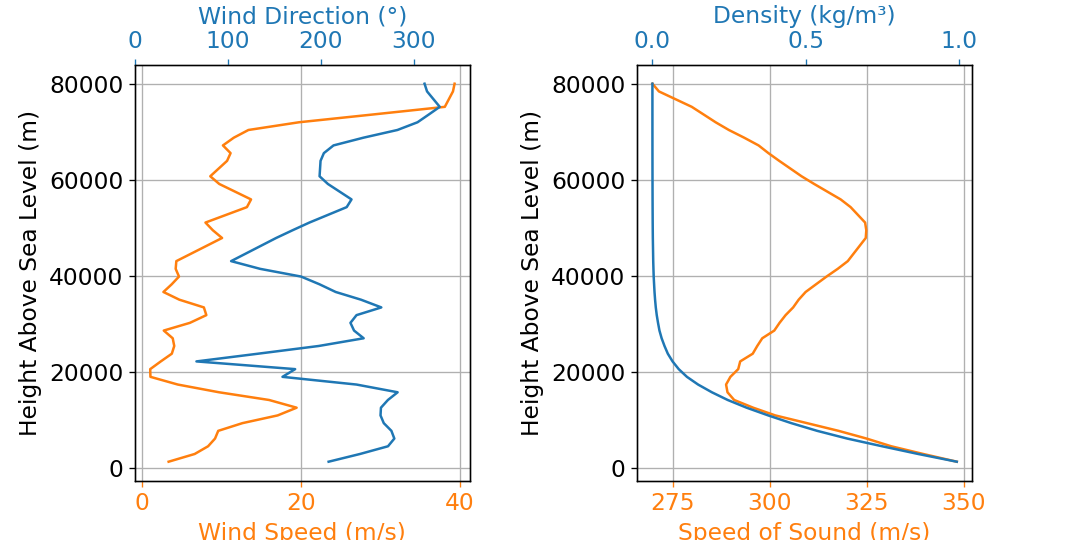

In [18]:
env.info()

/tmp/ipykernel_339/3125395885.py:60: RuntimeWarning: invalid value encountered in double_scalars
  mdot_eth = ((1/R_eth)*rho_ETH*(P_ethtank - Pc_test[i]))**(1/2)


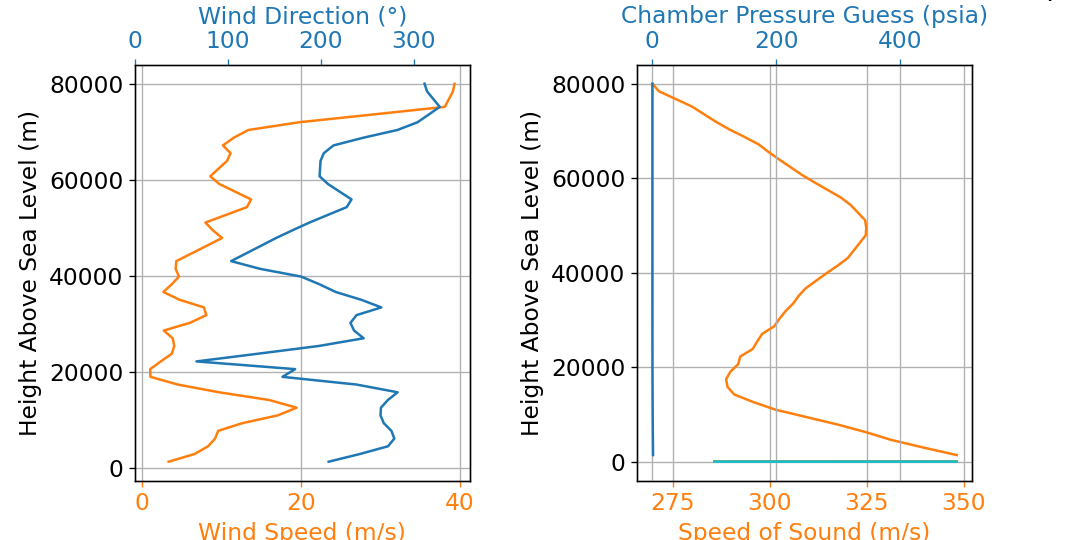

In [19]:
#Fluid Properties (SI units)
rho_LOX = 1140.0
rho_ETH = 798.0

#System Test Data Results
CdA_inj_LOX = 0.00001323 #Test For Cd
CdA_inj_ETH = 0.000009061 #Test For Cd

CdA_feed_LOX = 0.000040 #Test For Cd NEEDS DATA
CdA_feed_ETH = 0.00004046 #Test For Cd

#Hydraulic Resistance Terms
R_ox_inj = 1/(2*(CdA_inj_LOX**2)) #dP=Rhyd*mdot^2/rho
R_eth_inj = 1/(2*(CdA_inj_ETH**2)) #dP=Rhyd*mdot^2/rho

R_ox_feed = 1/(2*(CdA_feed_LOX**2)) #dP=Rhyd*mdot^2/rho
R_eth_feed = 1/(2*(CdA_feed_ETH**2)) #dP=Rhyd*mdot^2/rho

R_ox = R_ox_inj + R_ox_feed #Equivalent Hydraulic System Resistance
R_eth = R_eth_inj + R_ox_feed #Equivalent Hydraulic System Resistance

#Tank Properties
gamma_tanks = 1.41 #1.41=GN2, 1.67=GHe
V_oxtank = 6.926 #L
V_ethtank = 7.57 #L

V_oxinit = 3.85 #L OPTMIMIZE THIS
V_ethinit = 2.15 #L OPTIMIZE THIS

V_oxgas = V_oxtank-V_oxinit
V_ethgas = V_ethtank - V_ethinit

#Initial Tank Pressures
P_tank_ox_psi = 505.0 #psia
P_oxtank = P_tank_ox_psi*6895 #Pa

P_tank_eth_psi = 495.0 #psia
P_ethtank = P_tank_eth_psi*6895 #Pa

#define cstar efficiency: completeion of energy release. See RPE Pg64
Efficiency = 0.91
chamber = CEA_Obj(propName="", oxName="LOX", fuelName="C2H5OH") #initializs CEA object

#define Throat Diameter, Area
Dt = 27.54/1000 #m
At = (Dt**2)/4*math.pi

# Initialize Array
Residual = []

#create Chamber Pressure Guess Array
Pc_test_psi = np.linspace(100.0, (max(P_tank_ox_psi, P_tank_eth_psi)-1), 100) #psia
Pc_test = Pc_test_psi*6895 #Pa

#solve residual for each pressure guess
for i in range(len(Pc_test)):

    #solve mass flow from fluid resistances
    mdot_ox = ((1/R_ox)*rho_LOX*(P_oxtank - Pc_test[i]))**(1/2)
    mdot_eth = ((1/R_eth)*rho_ETH*(P_ethtank - Pc_test[i]))**(1/2)
    mdot_fluid = mdot_ox + mdot_eth
    #get OF ratio
    OF_ratio_test = mdot_ox/mdot_eth

    #solve mass flow from CEA
    Cstar_fps = chamber.get_Cstar(Pc=Pc_test_psi[i], MR=OF_ratio_test) #see RPE pg64
    Cstar = Cstar_fps*0.3048 #m
    mdot_CEA = Pc_test[i]*At/(Cstar*Efficiency) #kg/s

    #compare residual, append to array
    error = (mdot_CEA-mdot_fluid)/mdot_CEA
    Residual.append(abs(error))

    plt.plot(Pc_test_psi[:i+1], Residual[:i+1])
    plt.xlabel('Chamber Pressure Guess (psia)')
    plt.ylabel('Residual Error (abs(Ratio/1))')
    plt.title('Chamber Pressure - Residual Solution Space')
    plt.grid(True)


# Display the final plot after the loop
plt.show()

def Calculate_Residual(Pc, P_oxtank, P_ethtank):
    #solve mass flow from fluid resistances
    mdot_ox = ((1/R_ox)*rho_LOX*(P_oxtank - (Pc*6895)))**(1/2)
    mdot_eth = ((1/R_eth)*rho_ETH*(P_ethtank - (Pc*6895)))**(1/2)
    mdot_fluid = mdot_ox + mdot_eth
    #get OF ratio
    OF_ratio = mdot_ox/mdot_eth
    #solve mass flow from CEA
    Cstar_fps = chamber.get_Cstar(Pc = Pc[0], MR = OF_ratio[0]) #see RPE pg64
    Cstar = float(Cstar_fps*0.3048) #m/s
    if Cstar == 0:
        print("CSTAR ZERO")
        print(f"PC = {Pc[0]}")
        mdot_CEA_res = Pc*6895*At/(abs(Cstar)*Efficiency)
    else:
        mdot_CEA_res = (Pc*6895)*At/(Cstar*Efficiency) #kg/s

    #compare residual, append to array
    error = (mdot_CEA_res-mdot_fluid)/mdot_CEA_res

    global OF_ratio_glob
    OF_ratio_glob = float(OF_ratio[0])

    global mdot_total_glob
    mdot_total_glob = float(mdot_fluid[0])

    if OF_ratio > 2.5: #tank pressure drop eqs breaking
        error = 500

    return abs(error)

def GradientDescent(guess, P_oxtank, P_ethtank):
    # Use scipy optimize minimize with residual function to find Chamber Pressure
    result = minimize(
        Calculate_Residual,
        guess,
        args = (P_oxtank, P_ethtank),
        bounds = [(100, min([P_oxtank/6895, P_ethtank/6895]))],
    )
    P_chamber = result.x[0]
    # t = type(P_chamber)
    #print(f"Pchamb TYPE {t}")
    OF = OF_ratio_glob
    isp = chamber.estimate_Ambient_Isp(Pc=P_chamber,MR=OF,eps=4.35)[0]
    thrust = 9.8*isp*(mdot_total_glob)/1000 #kN
    print(f"Thrust {thrust}")
    massflow_total = mdot_total_glob
    print(f"massflow {massflow_total}")
    #print(f"PC {P_chamber/6895} and MR {OF_ratio} at {i*dt}")

    return P_chamber, thrust, OF, massflow_total


/tmp/ipykernel_339/3125395885.py:90: RuntimeWarning: divide by zero encountered in true_divide
  OF_ratio = mdot_ox/mdot_eth
/tmp/ipykernel_339/3125395885.py:97: RuntimeWarning: divide by zero encountered in true_divide
  mdot_CEA_res = Pc*6895*At/(abs(Cstar)*Efficiency)
/tmp/ipykernel_339/3125395885.py:102: RuntimeWarning: invalid value encountered in true_divide
  error = (mdot_CEA_res-mdot_fluid)/mdot_CEA_res


TIMESTEP 0.08032128514056225
CSTAR ZERO
PC = 494.99999999
Thrust 2.3777290721714492
massflow 0.945810367253789
CSTAR ZERO
PC = 490.5920063279308
Thrust 2.3462602180161687
massflow 0.9336455676167517
CSTAR ZERO
PC = 483.05156562738017
Thrust 2.310434165072753
massflow 0.9207768920135955
CSTAR ZERO
PC = 475.7978879526745
CSTAR ZERO
PC = 475.7978879526745
CSTAR ZERO
PC = 475.7978879526745
Thrust 2.2759127850617826
massflow 0.908405099700297
CSTAR ZERO
PC = 468.81354250484327
CSTAR ZERO
PC = 468.81354250484327
CSTAR ZERO
PC = 468.81354250484327
Thrust 2.2426184964374567
massflow 0.8964988476615571
Thrust 2.210480223936753
massflow 0.8850295873521858
Thrust 2.179432704751565
massflow 0.8739711448534045
Thrust 2.1494158331453446
massflow 0.863299453617482
Thrust 2.1203741870711816
massflow 0.8529924296934883
Thrust 2.092256527596024
massflow 0.8430297082437888
Thrust 2.065015318539561
massflow 0.8333924439635939
Thrust 2.0386065770769988
massflow 0.8240632809470849
Thrust 2.0129892811884122


/tmp/ipykernel_339/3125395885.py:86: RuntimeWarning: invalid value encountered in sqrt
  mdot_ox = ((1/R_ox)*rho_LOX*(P_oxtank - (Pc*6895)))**(1/2)


Thrust 1.4974894157237326
massflow 0.6349947993700568
Thrust 1.484958911125503
massflow 0.6306422766063235
Thrust 1.472665184323856
massflow 0.626372144173355
Thrust 1.4606010356948664
massflow 0.6221818259966427
Thrust 1.4487594713661003
massflow 0.6180688581520215
Thrust 1.4371340339752858
massflow 0.6140308810683055
Thrust 1.4257182689467276
massflow 0.6100656359442975
Thrust 1.4145060568961019
massflow 0.6061709585981181
Thrust 1.4034916023667392
massflow 0.6023447728502563
Thrust 1.3926691504314053
massflow 0.5985850909364269
Thrust 1.382033455164486
massflow 0.5948899995826904
Thrust 1.3715791640430783
massflow 0.5912576687078769
Thrust 1.3613013219368646
massflow 0.5876863361107246
Thrust 1.351195151062271
massflow 0.5841743079681887
Thrust 1.3412560486762555
massflow 0.5807199554234745
Thrust 1.3314794903153193
massflow 0.5773217157674244
Thrust 1.32186111023389
massflow 0.5739780863918005
Thrust 1.3123968715025423
massflow 0.5706876125320852
Thrust 1.3030827933449312
massflow 

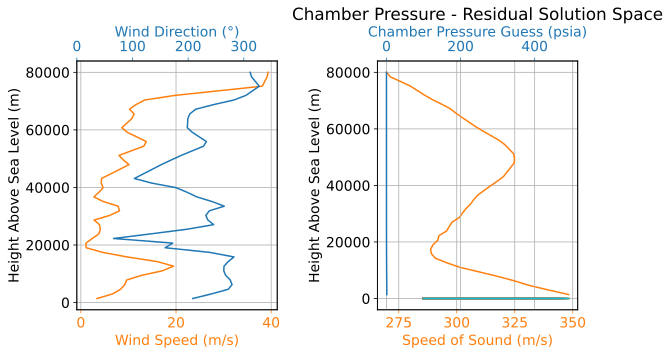

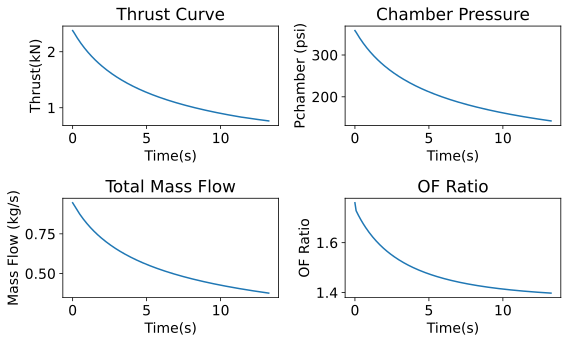

In [20]:
#reference thrust curve
iterations = 250
time = np.linspace(0, 20, iterations) #200 pts from 0 to 15 seconds
dt = float(time[1]-time[0])
print(f"TIMESTEP {dt}")
OF_array = []
Thrust_array = []
P_chamber_array = []
mdtot_array = []
fin = 0
for i in range(len(time)): #perform this for every timestep in the profile

    if i == 0:
        Pc_guess = 375
    else:
        Pc_guess = P_chamber_last-5

    P_chamber, Thrust, OF, md_tot = GradientDescent(Pc_guess, P_oxtank, P_ethtank)
    md_ox = md_tot/(
        1+1/OF)
    md_eth = md_tot-md_ox

    #print(f"Timestep {dt}")
    masslost_ox = md_ox*dt
    masslost_eth = md_eth*dt
    #print(f"masslostox {masslost_ox}")

    #print(f"Voxgas(L) {V_oxgas}")
    V_oxgas_next = V_oxgas + (masslost_ox/(rho_LOX*0.001))
    V_ethgas_next = V_ethgas + (masslost_eth/(rho_ETH*0.001))
    #print(f"Voxgasnext(L) {V_oxgas_next}")

    P_oxtank = P_oxtank*((V_oxgas/V_oxgas_next)**gamma_tanks)
    P_ethtank = P_ethtank*((V_ethgas/V_ethgas_next)**gamma_tanks)
    # print(f"Oxtank = {P_oxtank/6895}[psi] ... Ethtank = {P_ethtank/6895}[psi] at {i*dt}")

    V_oxgas = V_oxgas_next
    V_ethgas = V_oxgas_next

    mdtot_array.append(md_tot)
    OF_array.append(OF)
    Thrust_array.append(Thrust)
    P_chamber_array.append(P_chamber)
    assert len(Thrust_array) == len(P_chamber_array)
    P_chamber_last = P_chamber

    if P_chamber>(0.90*P_oxtank/6895) or P_chamber>(0.90*P_oxtank/6895):
        OxDrop = (P_oxtank/6895)/P_chamber
        ETHDrop = (P_ethtank/6895)/P_chamber
        print(f"Flow Stability Violated with {OxDrop}% LOXratio and {ETHDrop}% ETHratio")
        break

    if V_oxgas>=(V_oxtank-V_oxtank/500) or V_ethgas>=(V_ethtank-V_ethtank/500):
        oxrem = V_oxtank-V_oxgas
        ethrem = V_ethtank-V_ethgas
        print(f"Burn finished with {oxrem}L LOX and {ethrem}L ETH at Time {i*dt}s")
        break

# Create the subplots and plot the data
fig, axs = plt.subplots(2, 2)
sc = axs[0, 0].plot(time[0:len(Thrust_array)], Thrust_array)
axs[0, 0].set_title("Thrust Curve")
axs[0, 0].set_xlabel("Time(s)")
axs[0, 0].set_ylabel("Thrust(kN)")

axs[0, 1].plot(time[0:len(Thrust_array)], P_chamber_array)
axs[0, 1].set_title("Chamber Pressure")
axs[0, 1].set_xlabel("Time(s)")
axs[0, 1].set_ylabel("Pchamber (psi)")

axs[1, 0].plot(time[0:len(Thrust_array)], mdtot_array)
axs[1, 0].set_title("Total Mass Flow")
axs[1, 0].set_xlabel("Time(s)")
axs[1, 0].set_ylabel("Mass Flow (kg/s)")

axs[1, 1].plot(time[0:len(Thrust_array)], OF_array)
axs[1, 1].set_title("OF Ratio")
axs[1, 1].set_xlabel("Time(s)")
axs[1, 1].set_ylabel("OF Ratio")

# Adjust layout
plt.tight_layout()

# WRITE TO .ENG FILE
file_path = "../RocketPy-100a1/data/motors/LE2.eng"  # Specify the desired file path

if not os.path.exists(file_path):
    f = open(file_path, "x")
    f.close()

# Open the file for writing
with open(file_path, "w") as f:
    f.write("; ALULA - LE2 \n")
    f.write("; 8/1/2023 ver. \n")
    f.write("; created by UCB STAR \n")
    f.write("LE2 98 732 0 6.325 8.98822 ALULA\n")

    for i in range(len(Thrust_array)):
        f.write(f"{str(time[i])} {str(Thrust_array[i] * 1000)}\n")  # Thrust_array values in N

# Display the plots
%matplotlib inline
plt.show()

In [21]:
from rocketpy import LiquidMotor
Propmass = V_oxinit/1000*rho_LOX+V_ethinit/1000*rho_ETH
print(Propmass)
LiquidMotor.propellant_initial_mass = V_oxinit/1000*rho_LOX+V_ethinit/1000*rho_ETH

LE2 = LiquidMotor(    
            thrust_source="../RocketPy-100a1/data/motors/LE2.eng",
            dry_mass=12.685,
            center_of_dry_mass=1.107,
            dry_inertia=(7.332,7.333,0.0318,-0.00153,0.0219,0.0284),
            nozzle_radius=0.0515/2,
           # burn_time,
            nozzle_position=0,
            reshape_thrust_curve=False,
            interpolation_method="linear",
            coordinate_system_orientation="nozzle_to_combustion_chamber",
)


6.1047


Nozzle Details
Nozzle Radius: 0.02575 m

Motor Details
Total Burning Time: 13.25301204819277 s
Total Propellant Mass: 6.105 kg
Average Propellant Exhaust Velocity: nan m/s
Average Thrust: 1236.825 N
Maximum Thrust: 2346.260218016169 N at 0.08032128514056225 s after ignition.
Total Impulse: 16391.651 Ns



/home/jovyan/RocketPy-100a1/rocketpy/Function.py:2178: RuntimeWarning: divide by zero encountered in double_scalars
  return Function(lambda x: (self.get_value_opt(x) / other(x)))
/home/jovyan/RocketPy-100a1/rocketpy/Function.py:2487: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  ans, _ = integrate.quad(self, a, b, epsabs=0.001, limit=10000)


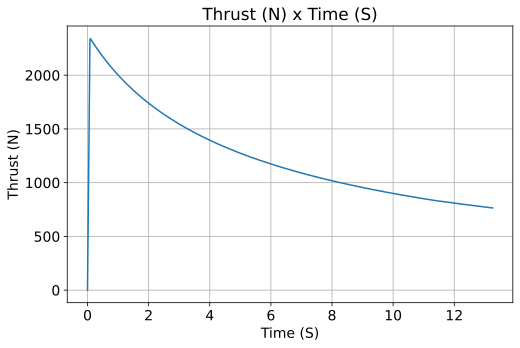

In [22]:
LE2.info()

In [23]:
ALULA = Rocket(
        #self,
        radius=0.0785,
        mass=36.338, #*0.9,     #  total dry
        inertia=(40.32089762,40.32707615,0.16968255,-0.00501791,-0.33114339,0.44168709),
        power_off_drag="../RocketPy-100a1/docs/notebooks/dispersion_analysis/dispersion_analysis_inputs/LE2_Inserts_Drag_-_Sheet1.csv", ##UPDATE
        power_on_drag="../RocketPy-100a1/docs/notebooks/dispersion_analysis/dispersion_analysis_inputs/LE2_Inserts_Drag_-_Sheet1.csv", ##UPDATE
        center_of_mass_without_motor=1.996, 
        coordinate_system_orientation="tail_to_nose",
)

railButtons = ALULA.set_rail_buttons(
    upper_button_position=0.18,
    lower_button_position=-1.4246,
    angular_position=60,
)

ALULA.add_motor(LE2, position=0) # origin = nozzle outlet

NoseCone = ALULA.add_nose(length=0.762, kind="vonKarman", position=3.99) 

FinSet = ALULA.add_trapezoidal_fins(
    n=3,
    root_chord =0.305,
    tip_chord=0.102,
    span=0.152,
    position=0.4,
    sweep_angle=33.7
)

In [24]:
ALULA.info()


Inertia Details

Rocket Mass: 36.338 kg (No Propellant)
Rocket Mass: 42.443 kg (With Propellant)
Rocket Inertia (with motor, but without propellant) 11: 55.084 kg*m2
Rocket Inertia (with motor, but without propellant) 22: 55.091 kg*m2
Rocket Inertia (with motor, but without propellant) 33: 0.201 kg*m2
Rocket Inertia (with motor, but without propellant) 12: -0.007 kg*m2
Rocket Inertia (with motor, but without propellant) 13: -0.309 kg*m2
Rocket Inertia (with motor, but without propellant) 23: 0.470 kg*m2


Geometrical Parameters

Rocket Maximum Radius: 0.0785 m
Rocket Frontal Area: 0.019359 m2

Rocket Distances
Rocket Center of Dry Mass - Nozzle Exit Distance: 1.766 m
Rocket Center of Dry Mass - Center of Propellant Mass: 1.766 m
Rocket Center of Mass - Rocket Loaded Center of Mass: 0.274 m

Aerodynamic Components Parameters
Currently not implemented.


Aerodynamics Lift Coefficient Derivatives

Nosecone Lift Coefficient Derivative: 2.000/rad
Fins Lift Coefficient Derivative: 6.707/rad

In [25]:
#ALULA.parachutes.remove(drogue)
#ALULA.parachutes.remove(main)

In [26]:
main = ALULA.add_parachute(
    name="main", #84"d - 120"d
    cd_s=3.464577329*2.2, #^7.07050353*2.2,
    trigger=457.2,  # ejection altitude: 1000ft
    sampling_rate=105,
    lag=0, #1.5
    noise=(0, 8.3, 0.5),
)

drogue = ALULA.add_parachute(
    name="drogue", #60''d
    cd_s=1.767638271*2.2,
    trigger="apogee",  # ejection at apogee
    sampling_rate=105,
    lag=0, #1.5
    noise=(0, 8.3, 0.5),
)

## Flight Results

In [27]:
test_flight = Flight(
  rocket=ALULA, environment=env, rail_length=18.288, inclination=85, heading=0
)


Initial Conditions

Position - x: 0.00 m | y: 0.00 m | z: 1471.33 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude - e0: 0.999 | e1: -0.044 | e2: -0.000 | e3: 0.000
Euler Angles - Spin φ : 0.00° | Nutation θ: -5.00° | Precession ψ: 0.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s| ω3: 0.00 rad/s


Surface Wind Conditions

Frontal Surface Wind Speed: 3.01 m/s
Lateral Surface Wind Speed: -1.62 m/s


Launch Rail

Launch Rail Length: 18.288  m
Launch Rail Inclination: 85.00°
Launch Rail Heading: 0.00°


Rail Departure State

Rail Departure Time: 0.919 s
Rail Departure Velocity: 36.324 m/s
Rail Departure Static Margin: 6.227 c
Rail Departure Angle of Attack: 5.401°
Rail Departure Thrust-Weight Ratio: 4.871
Rail Departure Reynolds Number: 3.028e+05


Burn out State

Burn out time: 13.253 s
Altitude at burn out: 2004.520 m (AGL)
Rocket velocity at burn out: 223.863 m/s
Freestream velocity at burn out: 224.285 m/s
Mach Number at burn out: 0.665
Kinetic energy at burn o

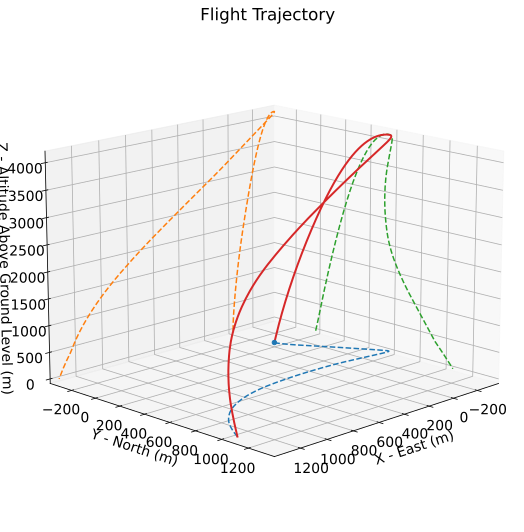



Trajectory Kinematic Plots



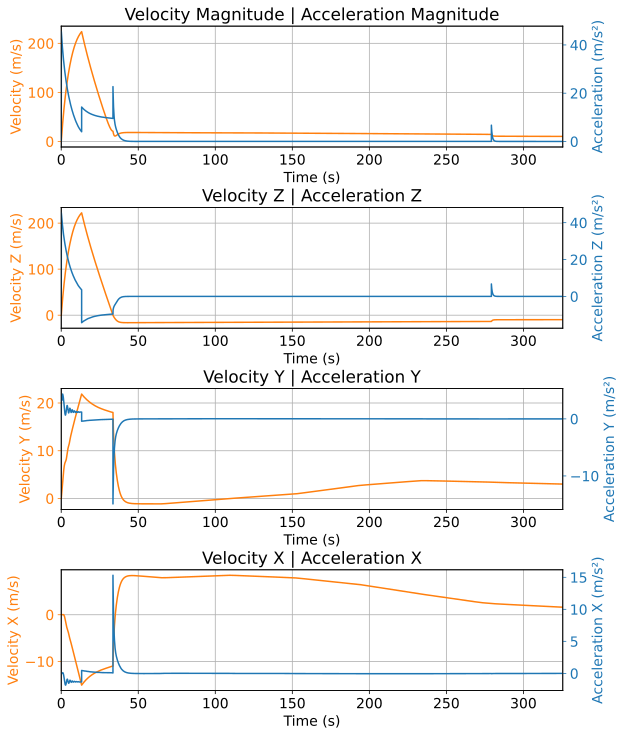



Angular Position Plots



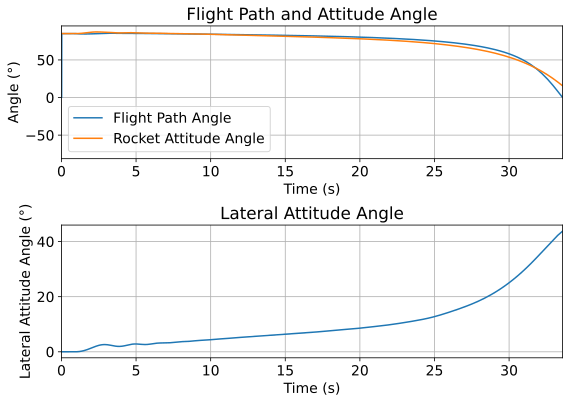



Path, Attitude and Lateral Attitude Angle plots



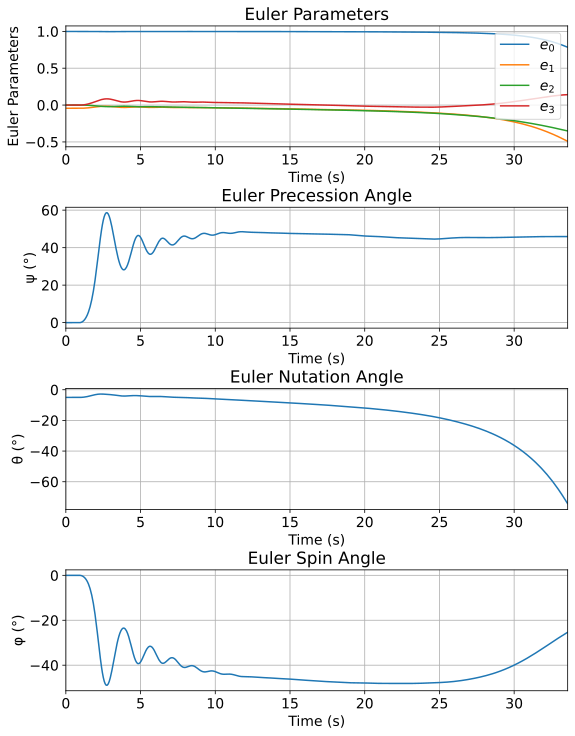



Trajectory Angular Velocity and Acceleration Plots



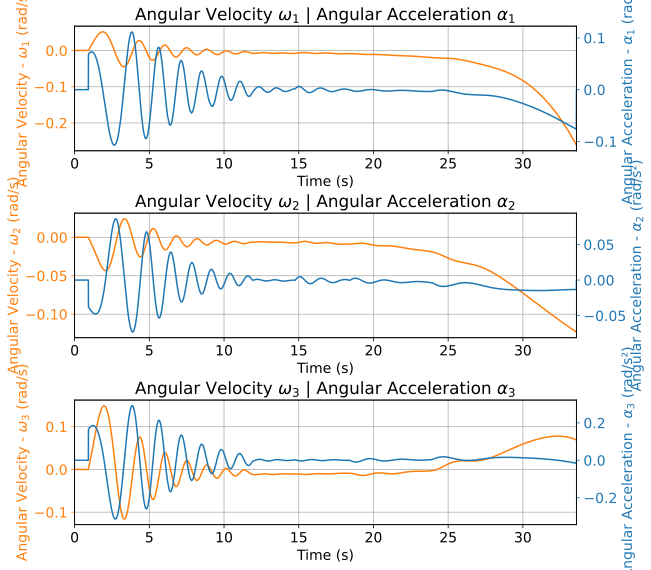



Aerodynamic Forces Plots



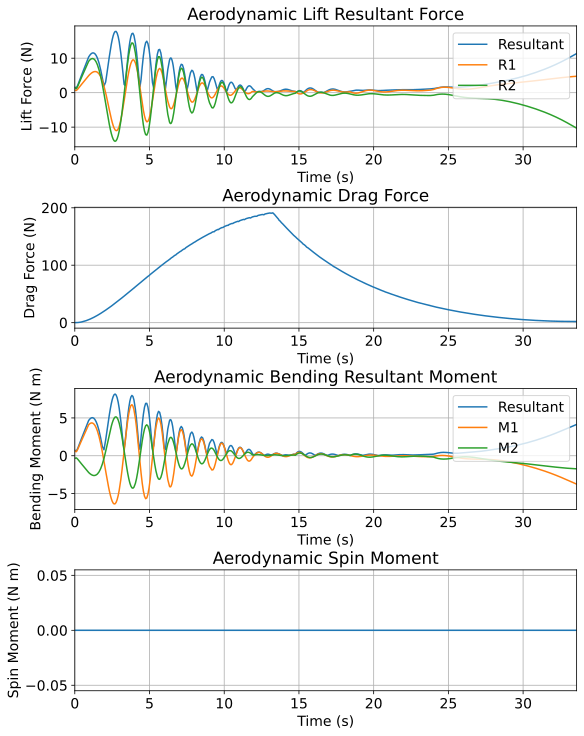



Rail Buttons Forces Plots



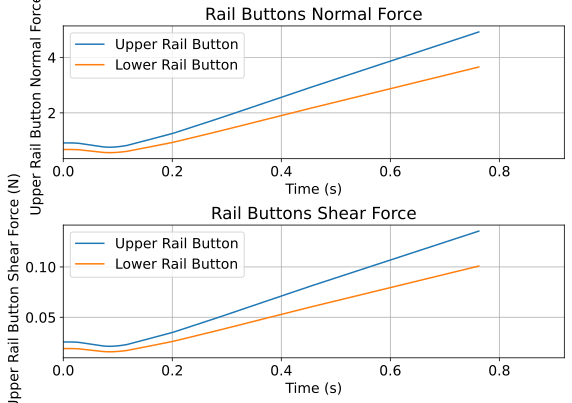



Trajectory Energy Plots



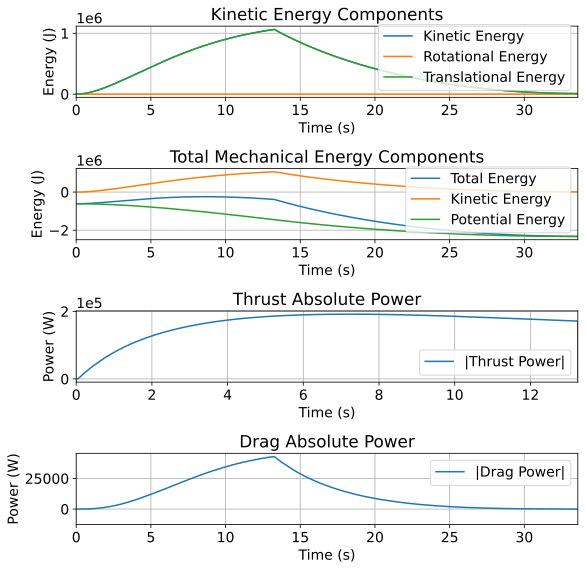



Trajectory Fluid Mechanics Plots



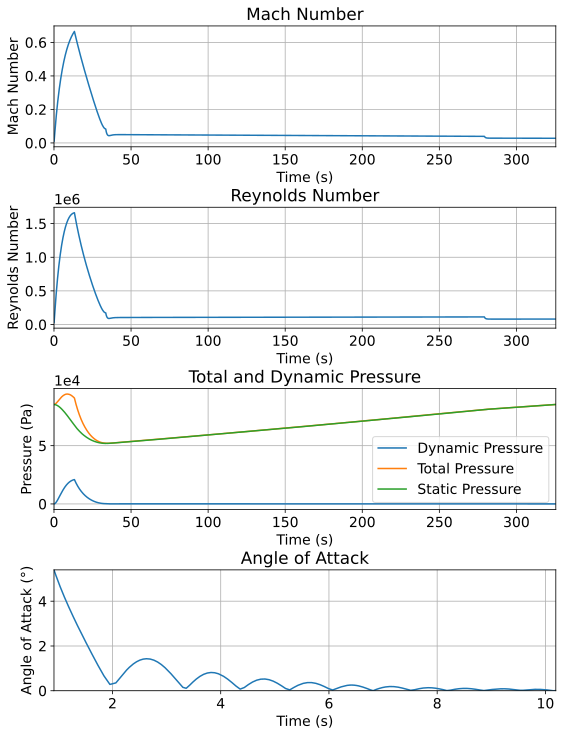



Trajectory Stability and Control Plots



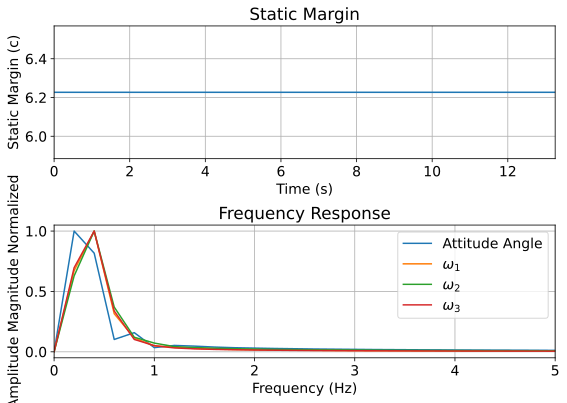



Rocket and Parachute Pressure Plots



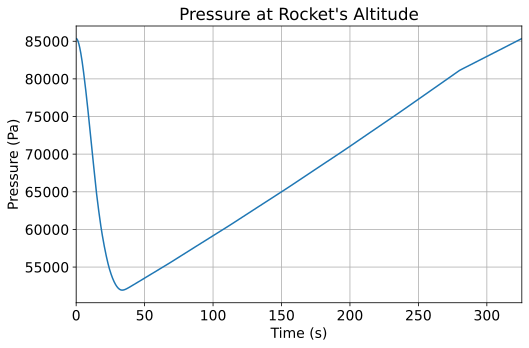


Parachute:  main


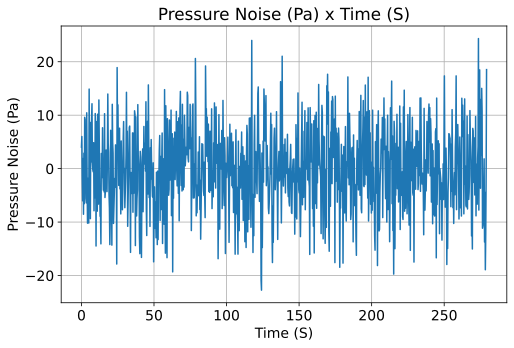

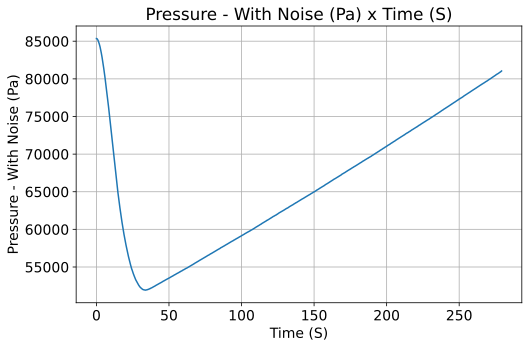

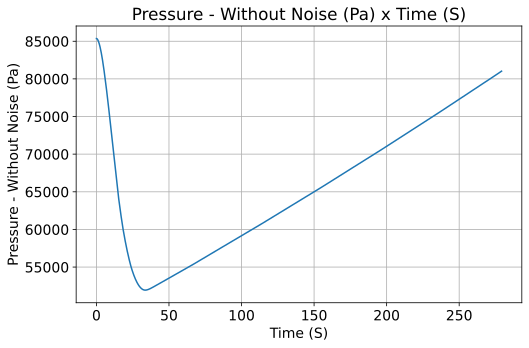


Parachute:  drogue


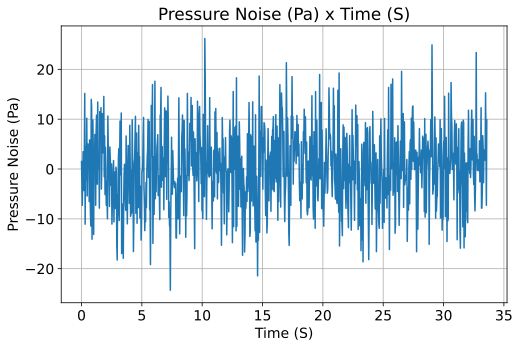

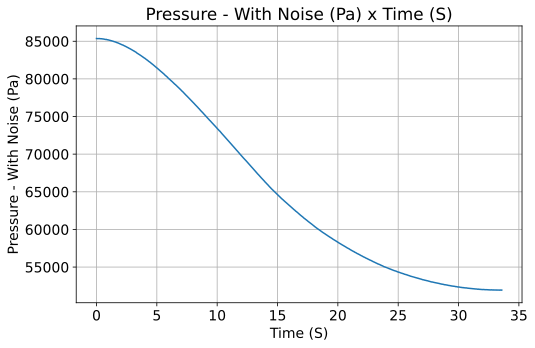

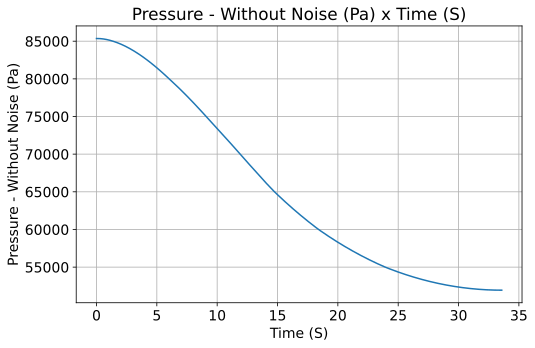

In [28]:
test_flight.all_info()

In [29]:
test_flight.export_kml(
    file_name="AlulaTestFlight.kml",
    extrude=True,
    altitude_mode="relativetoground",
) #Import kml file to Google Earth!

File  AlulaTestFlight.kml  saved with success!


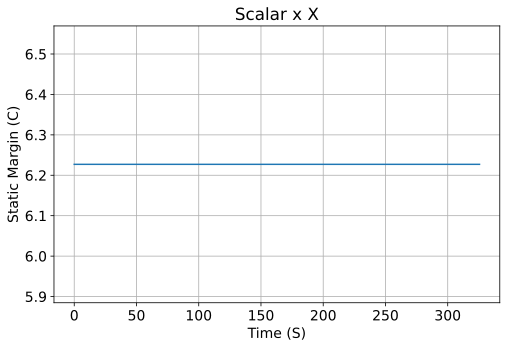

[6.22703636 6.22703636 6.22703636 6.22703636 6.22703636 6.22703636
 6.22703636 6.22703636 6.22703636 6.22703636 6.22703636 6.22703636
 6.22703636 6.22703636 6.22703636 6.22703636 6.22703636 6.22703636
 6.22703636 6.22703636 6.22703636 6.22703636 6.22703636 6.22703636
 6.22703636 6.22703636 6.22703636 6.22703636 6.22703636 6.22703636
 6.22703636 6.22703636 6.22703636 6.22703636 6.22703636 6.22703636
 6.22703636 6.22703636 6.22703636 6.22703636 6.22703636 6.22703636
 6.22703636 6.22703636 6.22703636 6.22703636 6.22703636 6.22703636
 6.22703636 6.22703636]


In [30]:
# Plot & Print static margin for entire flight
test_flight.static_margin.plot(0, test_flight.t_final)
print(test_flight.static_margin(np.linspace(0, test_flight.t_final))) 